In [1]:
# IMPORTS
import numpy as np # For math operations and working with arrays
import pandas as pd # Data manipulation and analysis, commonly used with ML
import os # To interact with the operating system
import matplotlib.pyplot as plt # Visualizations and plots
import torch # For machine learning and especially deep learning 
from sklearn.preprocessing import MinMaxScaler # Helps scale / normalize features in the data sets
from sklearn.model_selection import train_test_split # Split the data into Training and Testing sets
from tqdm import tqdm # Used to display progress bars

In [22]:
file_path = r'C:\Users\jwell\OneDrive\Desktop\scripts\GAIN Stocks Data.csv' # Denotes where the csv file is located, r means raw string
data = pd.read_csv(file_path) # Uses Pandas to create a DataFrame called data
#  A DataFrame is a table of data with rows and columns, where each column has a name and can hold data of the same type.
print(data.head()) # Prints the data, though .head() only prints the first 5. Removing it would print all of it but python limits it to first and last few.

    Date   Open   High    Low  Close    Volume
0  42095  40.60  40.76  40.31  40.72  36865322
1  42096  40.66  40.74  40.12  40.29  37487476
2  42100  40.34  41.78  40.18  41.55  39223692
3  42101  41.61  41.91  41.31  41.53  28809375
4  42102  41.48  41.69  41.04  41.42  24753438


0


<Axes: >

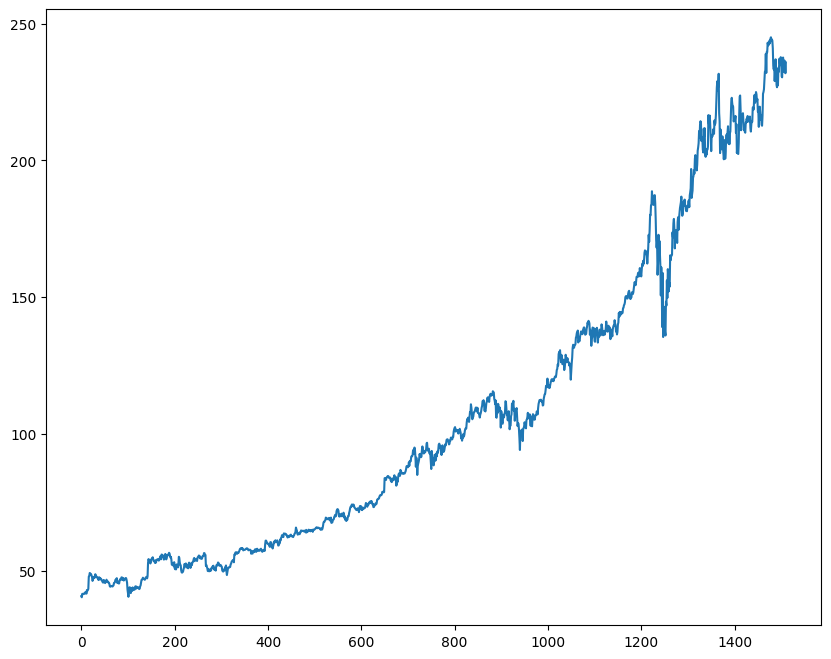

In [4]:
data_close = data['Close'] # Selects the row 'Close' and assigns it a new variable name

print(data_close.isna().sum()) # Checks for null values, adds them up, and prints how many

fig, ax = plt.subplots(figsize=(10, 8)) # Creates a graph

data_close.plot(ax=ax) # Plots data close and displays it

In [5]:
TEST_SIZE = 0.15

train, test = train_test_split(data_close.values, test_size=TEST_SIZE, shuffle=False)

print('size: train {}, test {}'.format(train.shape, test.shape))

size: train (1284,), test (227,)


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = np.squeeze(scaler.fit_transform(train.reshape(-1, 1)))
test_scaled = np.squeeze(scaler.transform(test.reshape(-1, 1)))


print('size: train {}, test {}'.format(train_scaled.shape, test_scaled.shape))

size: train (1284,), test (227,)


In [7]:
def split_sequence(sequence, n_step_in, n_step_out=1):
    X, y = list(), list()

    for i in range(len(sequence) - n_step_in - n_step_out + 1):
        X.append(sequence[i:i + n_step_in])
        y.append(sequence[i + n_step_in: i + n_step_in + n_step_out])

    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(y), dtype=torch.float)

In [8]:
N_STEP_IN = 90

X_train, y_train = split_sequence(train_scaled, N_STEP_IN)

print(X_train[1000:1002], y_train[1000:1002])
print('size: train {}, test {}'.format(X_train.shape, y_train.shape))

tensor([[0.0344, 0.0427, 0.0460, 0.0307, 0.0328, 0.0464, 0.0610, 0.0633, 0.0738,
         0.0656, 0.0727, 0.0732, 0.0645, 0.0767, 0.0786, 0.0870, 0.0883, 0.0846,
         0.0980, 0.1196, 0.1249, 0.1475, 0.1417, 0.1975, 0.2075, 0.2058, 0.2170,
         0.1804, 0.1579, 0.1941, 0.1840, 0.1486, 0.1484, 0.1483, 0.1703, 0.1193,
         0.1379, 0.1553, 0.1945, 0.1829, 0.1580, 0.1672, 0.1775, 0.1575, 0.1583,
         0.1572, 0.1408, 0.1514, 0.1238, 0.0720, 0.1168, 0.1528, 0.1796, 0.2278,
         0.2440, 0.2372, 0.2290, 0.2402, 0.2420, 0.2474, 0.2785, 0.2856, 0.3026,
         0.3029, 0.3138, 0.2552, 0.2619, 0.2649, 0.2623, 0.2855, 0.2976, 0.3095,
         0.3041, 0.3027, 0.2960, 0.3147, 0.3221, 0.3289, 0.3289, 0.3044, 0.2934,
         0.2955, 0.2982, 0.3226, 0.3341, 0.3534, 0.3463, 0.3618, 0.3576, 0.3484],
        [0.0427, 0.0460, 0.0307, 0.0328, 0.0464, 0.0610, 0.0633, 0.0738, 0.0656,
         0.0727, 0.0732, 0.0645, 0.0767, 0.0786, 0.0870, 0.0883, 0.0846, 0.0980,
         0.1196, 0.1249, 0.

In [9]:
X_test, y_test = split_sequence(test_scaled, N_STEP_IN)

print('size: train {}, test {}'.format(X_test.shape, y_test.shape))

size: train torch.Size([137, 90]), test torch.Size([137, 1])


In [10]:
X_train = X_train.reshape(-1, N_STEP_IN, 1)
X_test = X_test.reshape(-1, N_STEP_IN, 1)

print(X_train.shape, X_test.shape)

torch.Size([1194, 90, 1]) torch.Size([137, 90, 1])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class LSTM(torch.nn.Module):

    def __init__(self, num_features, hidden_units, num_layers):

        super(LSTM, self).__init__()

        self.lstm = torch.nn.LSTM(

            input_size=num_features,

            hidden_size=hidden_units,

            num_layers=num_layers,

            batch_first=True

        )

        self.output = torch.nn.Linear(

            in_features=hidden_units,

            out_features=1

        )

       
    def forward(self, X):

        X, _ = self.lstm(X) 

        X = X[:, -1, :]

        X = self.output(X)  

        return X

model = LSTM(1, 32, 1)

model.to(device)

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
def train(model, dataloader, optimizer, loss_fn):

    model.train()

    loss_arr = list()

    for X_batch, y_batch in dataloader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)

        loss = loss_fn(torch.squeeze(y_batch), torch.squeeze(y_pred))

        loss_arr.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    return np.mean(loss_arr)

In [14]:
def evaluation(model, dataloader, optimizer, loss_fn, get_prediction=True):

    model.eval()
    loss_arr = list()
    pred_arr = list()

    with torch.no_grad():

        for X_batch, y_batch in dataloader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            if get_prediction:

                pred_arr.extend(y_pred.cpu().numpy())

            loss = loss_fn(torch.squeeze(y_batch), torch.squeeze(y_pred))
            loss_arr.append(loss.item())

    return np.array(pred_arr), np.mean(loss_arr)

In [15]:
def trainer(model, epochs, trainloader, testloader, optimizer, loss_fn, log_step):

    if log_step > epochs:

        raise Exception('log step cannot be smaller than epochs')

    result = {

        'epoch': list(),

        'train loss': list(),

        'test loss': list()

    }

    for epoch in tqdm(range(epochs)):

        train_loss = train(model, trainloader, optimizer, loss_fn)
        if epoch % log_step == 0:

            _, test_loss = evaluation(model, testloader, optimizer, loss_fn, get_prediction=False)

            result['epoch'].append(epoch)

            result['train loss'].append(train_loss)

            result['test loss'].append(test_loss)

    return result

In [16]:
N_EPOCHS = 50
BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=False, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

LOG_STEP = 20

res = trainer(model, N_EPOCHS, trainloader, testloader, optimizer, loss_fn, LOG_STEP)

100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


<Axes: xlabel='epoch'>

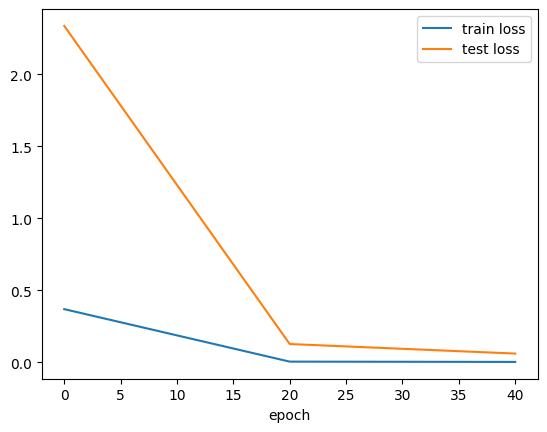

In [17]:
res_df = pd.DataFrame(res).set_index('epoch')

res_df.plot()

In [18]:
test_df = data_close.iloc[-len(y_test):].copy()
pred, avg_eval_loss = evaluation(model, testloader, optimizer, loss_fn)

print(avg_eval_loss)

0.015427523385733366


<Axes: >

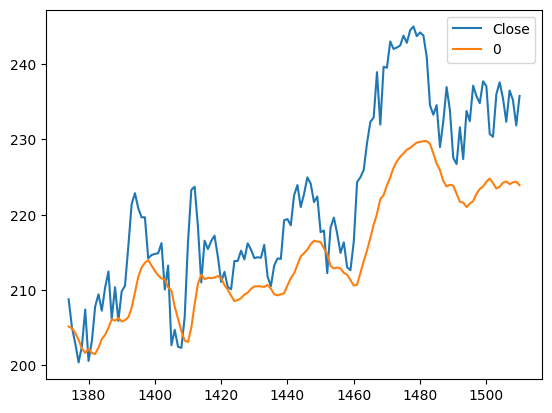

In [19]:
test_df = pd.concat([test_df, pd.DataFrame(scaler.inverse_transform(pred), index=test_df.index)], axis=1)

test_df.plot()

100%|██████████| 50/50 [00:07<00:00,  6.64it/s]

0.029905475303530694


<Axes: >

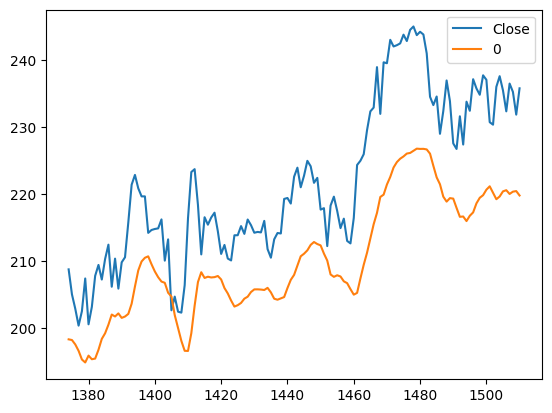

In [20]:
model2 = LSTM(1, 32, 1)

model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters())

res2 = trainer(model2,

               N_EPOCHS,

               torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE),

               torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=True, batch_size=BATCH_SIZE),

               optimizer2,

               loss_fn,

               LOG_STEP)

test_df = data_close.iloc[-len(y_test):].copy()

pred, avg_eval_loss = evaluation(model2,

    torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE), optimizer2, loss_fn)

print(avg_eval_loss)

test_df = pd.concat([test_df, pd.DataFrame(scaler.inverse_transform(pred), index=test_df.index)], axis=1)

test_df.plot()